#**Data Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [ ]:
file_path = 'data.csv'

df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df.rename(columns={"Bankrupt?": "Bankruptcy"}, inplace=True)
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1. Data Cleaning**

In [ ]:
#checking for missing and duplicate instances
print('Number of missing values in the dataset:\n', df.isnull().sum().sum())
print('\nNumber of duplicate rows:', df.duplicated().sum())

Number of missing values in the dataset:
 0

Number of duplicate rows: 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankruptcy                                               6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

In [ ]:
df.describe()

,Bankruptcy,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.1

In [ ]:
#checking for infity values
inf_counts = np.isinf(df).sum()
total_inf = inf_counts.sum()

print(f"Total infinity values found: {total_inf}")

if total_inf > 0:
    print("\nColumns with infinity values:")
    print(inf_counts[inf_counts > 0])

    #if we find values we replace them with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
else:
    print("No infinity values found.")

Total infinity values found: 0
No infinity values found.


In [ ]:
#we will check for features that have the same value for every instance
#if any, it will be deleted
selector = VarianceThreshold(threshold=0)
selector.fit(df)


constant_cols = df.columns[~selector.get_support()]

print(f"Features with zero variance: {len(constant_cols)}")

if len(constant_cols) > 0:
    print(list(constant_cols))

    df.drop(columns=constant_cols, inplace=True)
else:
    print("No features with zero variance.")
#

print(f"Final number of features: {df.shape[1]}")

Features with zero variance: 1
['Net Income Flag']
Final number of features: 95


#**2. Feature Selection**

In [ ]:
X = df.drop('Bankruptcy', axis=1)
y = df['Bankruptcy']

#we use spearman method for non-linear correlations
corr_matrix = X.corr(method='spearman').abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#we will drop high correlated variables (correlation > 0.8)
threshold = 0.8
cols_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
print('Features **before** removing cols with correlation > 0.8:', X.shape[1])
X.drop(columns=cols_to_drop, inplace=True)
print('Features **after** removing cols with correlation > 0.8:', X.shape[1])


Features **before** removing cols with correlation > 0.8: 94
Features **after** removing cols with correlation > 0.8: 40


In [ ]:
#values transformation, range from 0 to 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns

##**2.1 t-Test**

In [ ]:
#t-test method
t_scores = []
p_values = []

for i in range(X_scaled.shape[1]):

    #split the data in the classes
    group_0 = X_scaled[y == 0, i]
    group_1 = X_scaled[y == 1, i]


    t_stat, p_val = stats.ttest_ind(group_0, group_1, equal_var=False)
    t_scores.append(abs(t_stat))
    p_values.append(p_val)



t_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': t_scores,
    'p_value': p_values
})

t_df = t_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

##**2.2 Lasso Method**

In [ ]:
#feature selection with lasso
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, random_state=42)
lasso.fit(X_scaled, y)


lasso_scores = np.abs(lasso.coef_[0])


lasso_df = pd.DataFrame({'Feature': feature_names, 'Score': lasso_scores})
lasso_df = lasso_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

In [ ]:
final_output = pd.concat([
    t_df.rename(columns={'Feature': 'Ttest_Feature', 'Score': 'Ttest_Score'}),
    lasso_df.rename(columns={'Feature': 'LASSO_Feature', 'Score': 'LASSO_Score'})
], axis=1)


save_path1 = 'feature_selection_results.csv'


final_output.to_csv(save_path1, index=False)

In [ ]:
final_output.head(30)

,Ttest_Feature,Ttest_Score,p_value,LASSO_Feature,LASSO_Score
0,Net Value Per Share (B),21.988655,2.705630e-61,ROA(C) before interest and depreciation before...,14.168281
1,Cash/Total Assets,16.274190,1.207170e-42,Cash/Total Assets,7.254928
2,ROA(C) before interest and depreciation before...,16.250508,7.042946e-40,Tax rate (A),2.194288
3,Tax rate (A),11.068270,2.650956e-23,Net Value Per Share (B),1.097096
4,Operating Gross Margin,9.531937,1.843466e-18,Fixed Assets Turnover Frequency,0.831552
5,Cash flow rate,8.848392,1.539802e-16,Liability-Assets Flag,0.816949
6,Quick Assets/Total Assets,7.402392,2.371447e-12,Cash Turnover Rate,0.500412
7,Total expense/Assets,5.802302,2.235793e-08,Quick Assets/Total Assets,0.417917
8,Interest-bearing debt interest rate,5.627803,3.286425e-08,Current Assets/Total Assets,0.281541
9,Fixed Assets Turnover Frequency,4.750365,3.593307e-06,Total Asset Growth Rate,0.207725


##**2.3 Final Selection**

In [ ]:
#we will keep features with p_value < 0.05 and
#non-zero lasso scores
t_test_selected = t_df[t_df['p_value'] < 0.05]['Feature'].tolist()
lasso_selected = lasso_df[lasso_df['Score'] > 0]['Feature'].tolist()

# if a feature appears more than one time with "set()" we remove dublicates.
finalFeatures = sorted(list(set(t_test_selected + lasso_selected)))

print('Features are the following:\n')
for i, feature in enumerate(finalFeatures):
    print(i+1, feature)
print('\nThe number of Features is: ', len(finalFeatures))

Features are the following:

1 After-tax Net Profit Growth Rate
2 Cash Turnover Rate
3 Cash flow rate
4 Cash/Total Assets
5 Current Assets/Total Assets
6 Fixed Assets Turnover Frequency
7 Interest-bearing debt interest rate
8 Inventory Turnover Rate (times)
9 Inventory and accounts receivable/Net value
10 Liability-Assets Flag
11 Net Value Per Share (B)
12 Non-industry income and expenditure/revenue
13 Operating Expense Rate
14 Operating Gross Margin
15 Quick Asset Turnover Rate
16 Quick Assets/Total Assets
17 ROA(C) before interest and depreciation before interest
18 Research and development expense rate
19 Revenue Per Share (Yuan ¥)
20 Tax rate (A)
21 Total Asset Growth Rate
22 Total expense/Assets

The number of Features is:  22


###**2.3.1 Features from Literature**

In [ ]:
literature_features = [
    'Debt ratio %',
    'Net Income to Total Assets',
    'Retained Earnings to Total Assets',
    'Working Capital to Total Assets',
    'Current Ratio',
    'Total debt/Total net worth'
]

finalFeatures = sorted(list(set(finalFeatures + literature_features)))

In [ ]:
df[finalFeatures + ['Bankruptcy']].to_csv('finalData.csv', index=False)

#**3. Visualization**

In [ ]:
df_final = pd.read_csv('finalData.csv')
df_final.shape
display(df_final.head())

X = df_final.drop('Bankruptcy', axis=1)
y = df_final['Bankruptcy']

,After-tax Net Profit Growth Rate,Cash Turnover Rate,Cash flow rate,Cash/Total Assets,Current Assets/Total Assets,Current Ratio,Debt ratio %,Fixed Assets Turnover Frequency,Interest-bearing debt interest rate,Inventory Turnover Rate (times),Inventory and accounts receivable/Net value,Liability-Assets Flag,Net Income to Total Assets,Net Value Per Share (B),Non-industry income and expenditure/revenue,Operating Expense Rate,Operating Gross Margin,Quick Asset Turnover Rate,Quick Assets/Total Assets,ROA(C) before interest and depreciation before interest,Research and development expense rate,Retained Earnings to Total Assets,Revenue Per Share (Yuan ¥),Tax rate (A),Total Asset Growth Rate,Total debt/Total net worth,Total expense/Assets,Working Capital to Total Assets,Bankruptcy
0,0.688979,4.580000e+08,0.458143,0.004094,0.190643,0.002259,0.207576,1.165007e-04,0.000725,1.820926e-04,0.398036,0,0.716845,0.147950,0.302646,1.256969e-04,0.601457,6.550000e+09,0.166673,0.370594,0.0,0.903225,0.017560,0.0,4.980000e+09,0.021266,0.064856,0.672775,1
1,0.689693,2.490000e+09,0.461867,0.014948,0.182419,0.006016,0.171176,7.190000e+08,0.000647,9.360000e+09,0.397725,0,0.795297,0.182251,0.303556,2.897851e-04,0.610235,7.700000e+09,0.127236,0.464291,0.0,0.931065,0.021144,0.0,6.110000e+09,0.012502,0.025516,0.751111,1
2,0.689463,7.610000e+08,0.458521,0.000991,0.602806,0.011543,0.207516,2.650000e+09,0.000790,6.500000e+07,0.406580,0,0.774670,0.177911,0.302035,2.361297e-04,0.601450,1.022676e-03,0.340201,0.426071,25500000.0,0.909903,0.005944,0.0,7.280000e+09,0.021248,0.021387,0.829502,1
3,0.689110,2.030000e+09,0.465705,0.018851,0.225815,0.004194,0.151465,9.150000e+09,0.000449,7.130000e+09,0.397925,0,0.739555,0.154187,0.303350,1.078888e-04,0.583541,6.050000e+09,0.161575,0.399844,0.0,0.906902,0.014368,0.0,4.880000e+09,0.009572,0.024161,0.725754,1
4,0.689697,8.240000e+08,0.462746,0.014161,0.358380,0.006022,0.106509,2.935211e-04,0.000686,1.633674e-04,0.400079,0,0.795016,0.167502,0.303475,7.890000e+09,0.598783,5.050000e+09,0.260330,0.465022,0.0,0.913850,0.029690,0.0,5.510000e+09,0.005150,0.026385,0.751822,1


In [ ]:
df_final.columns

Index(['After-tax Net Profit Growth Rate', 'Cash Turnover Rate',
       'Cash flow rate', 'Cash/Total Assets', 'Current Assets/Total Assets',
       'Current Ratio', 'Debt ratio %', 'Fixed Assets Turnover Frequency',
       'Interest-bearing debt interest rate',
       'Inventory Turnover Rate (times)',
       'Inventory and accounts receivable/Net value', 'Liability-Assets Flag',
       'Net Income to Total Assets', 'Net Value Per Share (B)',
       'Non-industry income and expenditure/revenue', 'Operating Expense Rate',
       'Operating Gross Margin', 'Quick Asset Turnover Rate',
       'Quick Assets/Total Assets',
       'ROA(C) before interest and depreciation before interest',
       'Research and development expense rate',
       'Retained Earnings to Total Assets', 'Revenue Per Share (Yuan ¥)',
       'Tax rate (A)', 'Total Asset Growth Rate', 'Total debt/Total net worth',
       'Total expense/Assets', 'Working Capital to Total Assets',
       'Bankruptcy'],
      dtype='objec

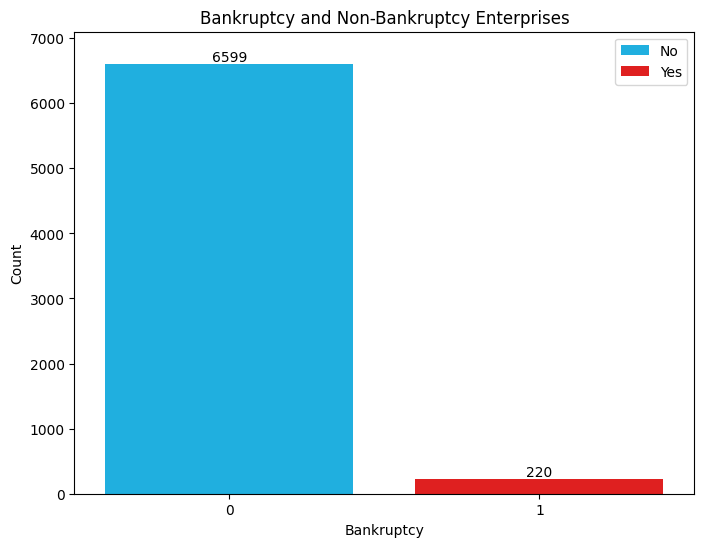

In [ ]:
color_dict = {0: "deepskyblue", 1: "red"}
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_final, x='Bankruptcy', palette=color_dict, hue='Bankruptcy', legend=True)
plt.ylabel('Count')
plt.ylim(0, df_final['Bankruptcy'].value_counts().max() + 500)
plt.legend(labels=['No', 'Yes'])
plt.title('Bankruptcy and Non-Bankruptcy Enterprises')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

##**3.1 Yeo-Johnson Transformation**

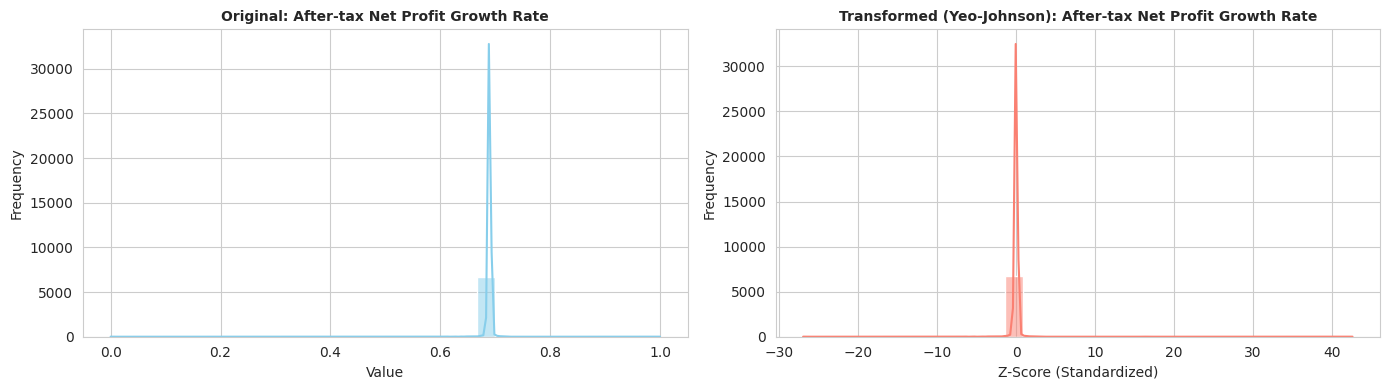

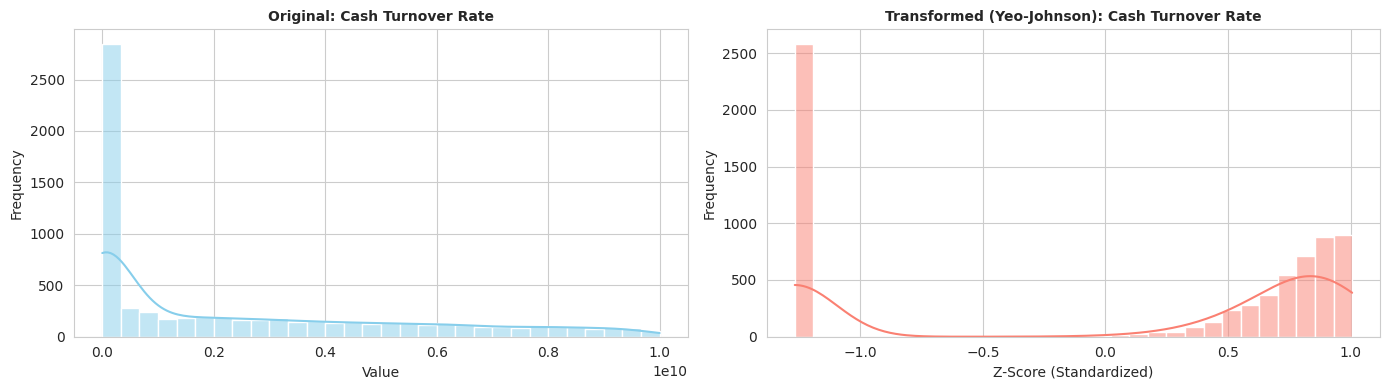

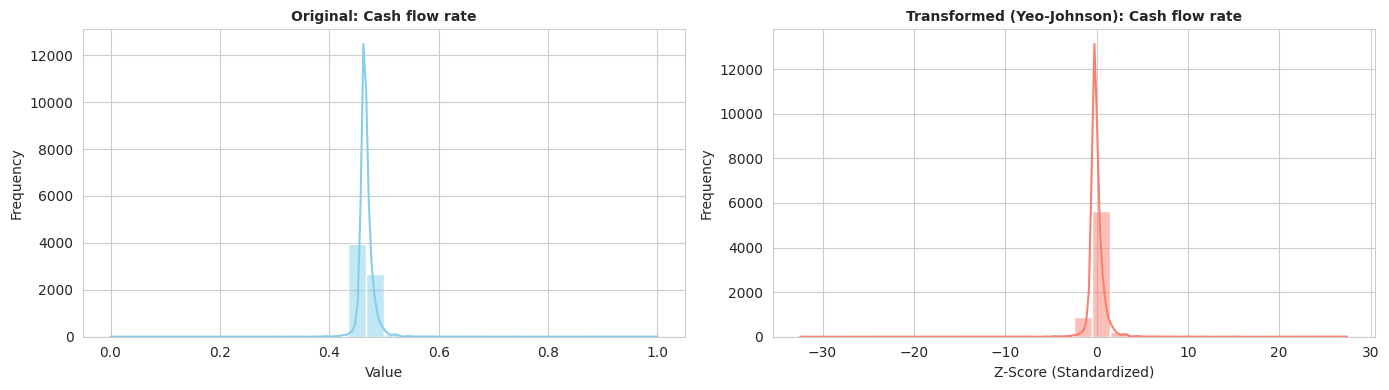

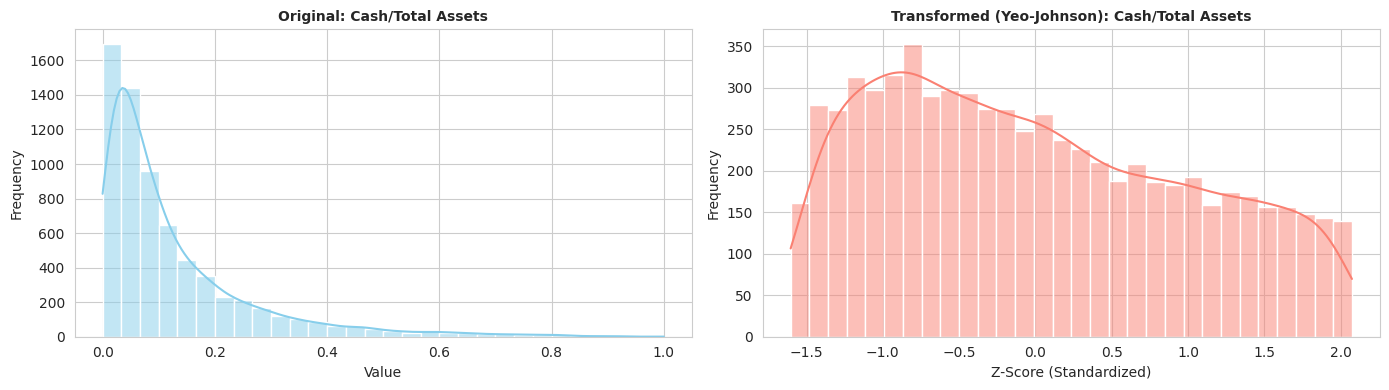

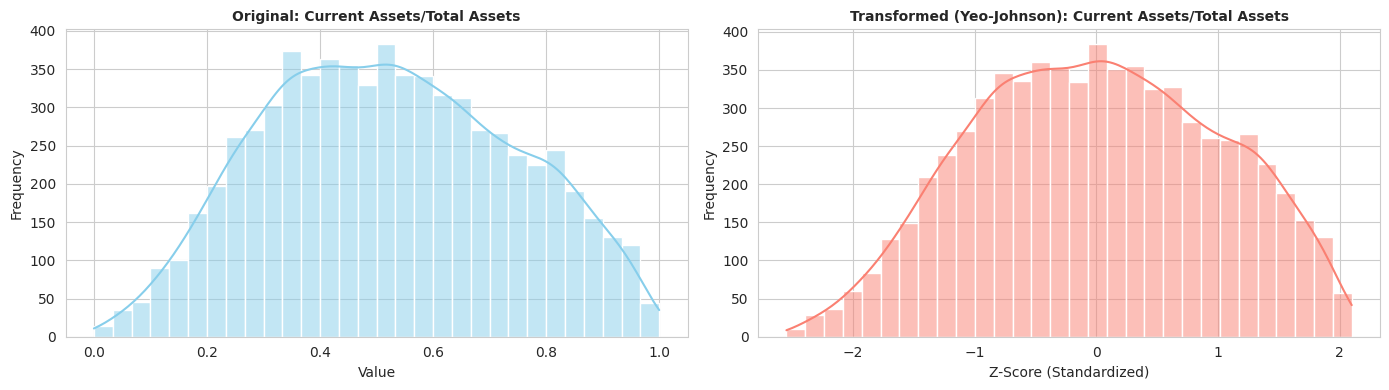

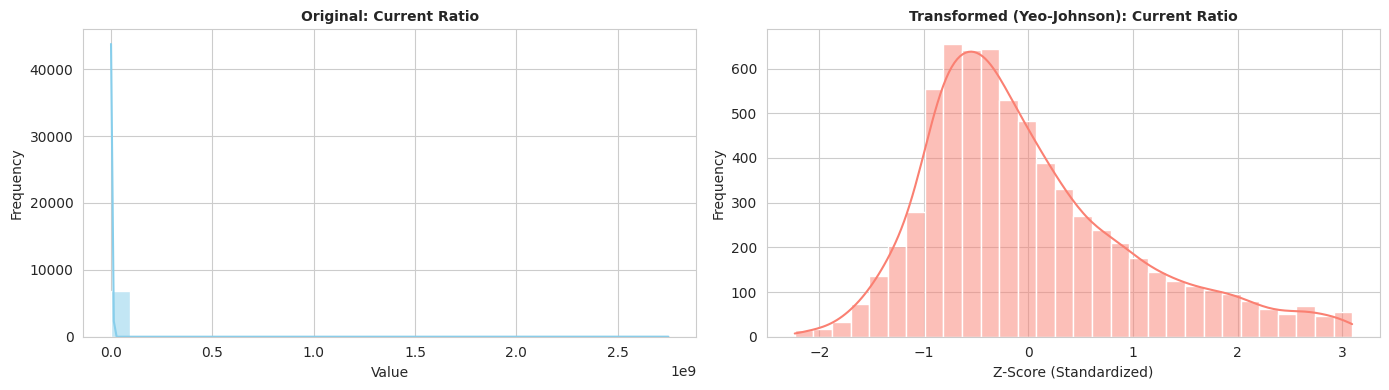

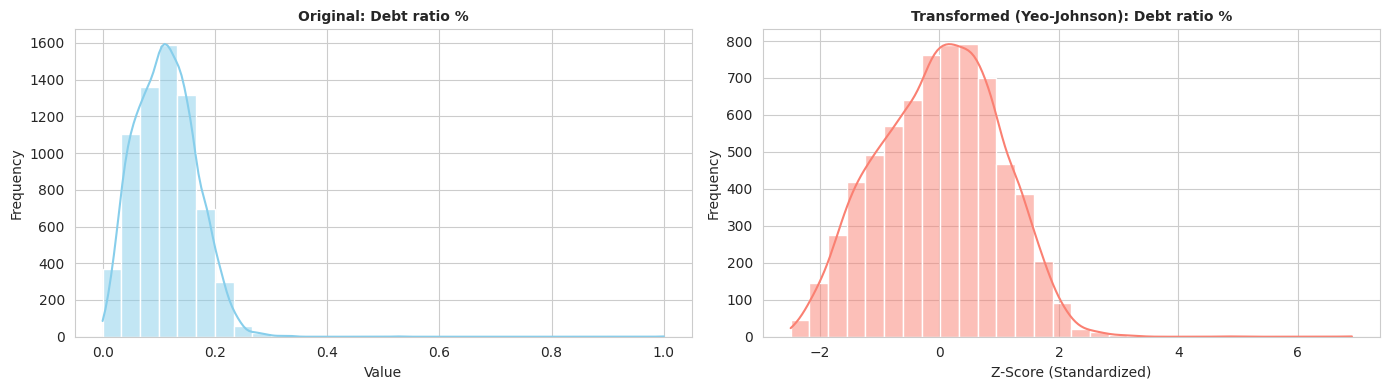

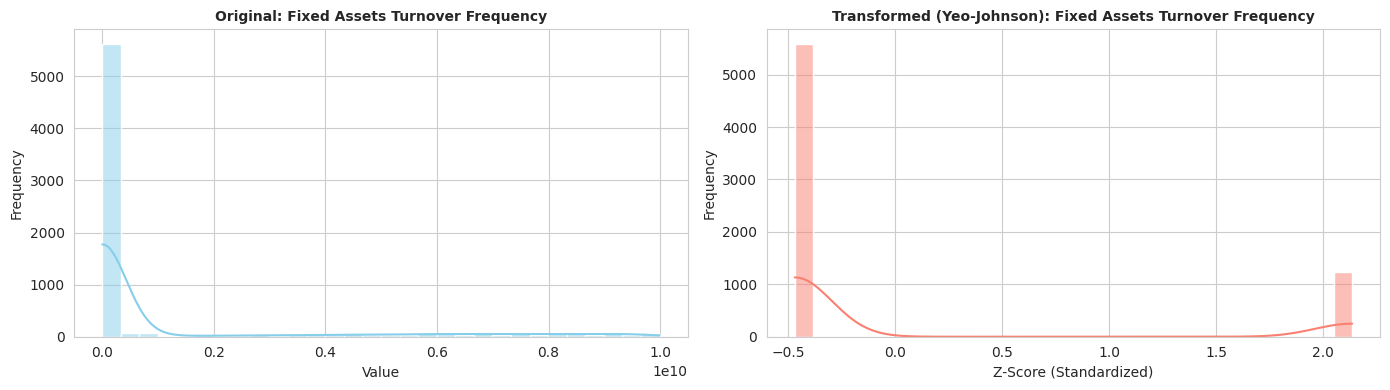

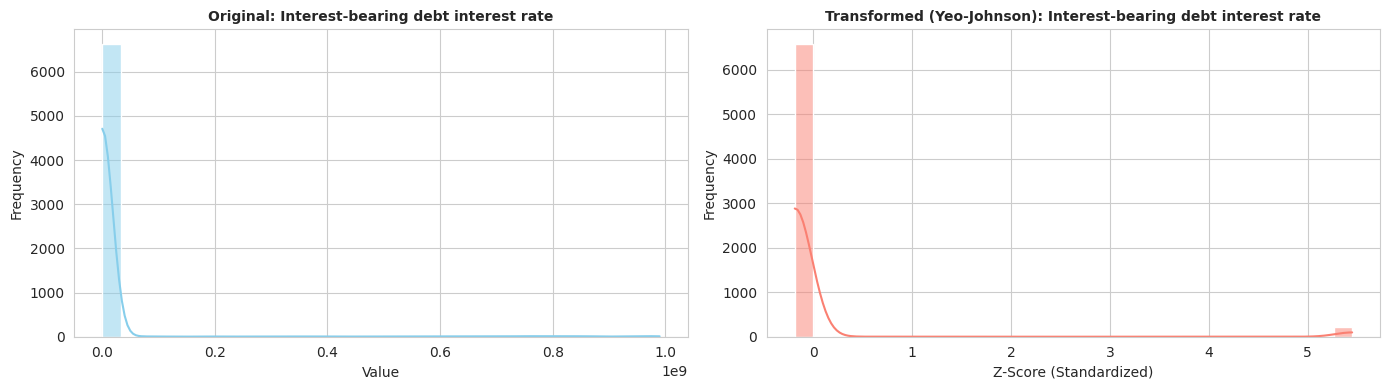

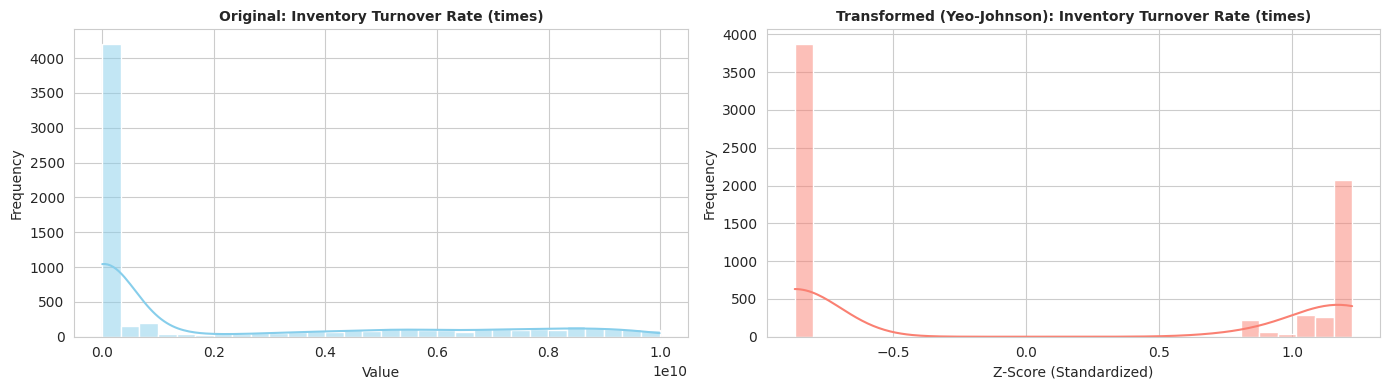

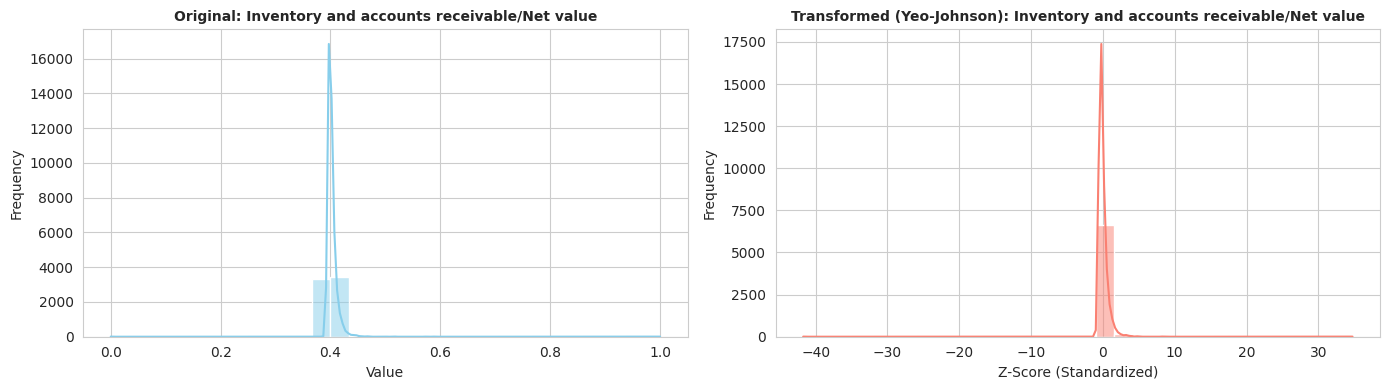

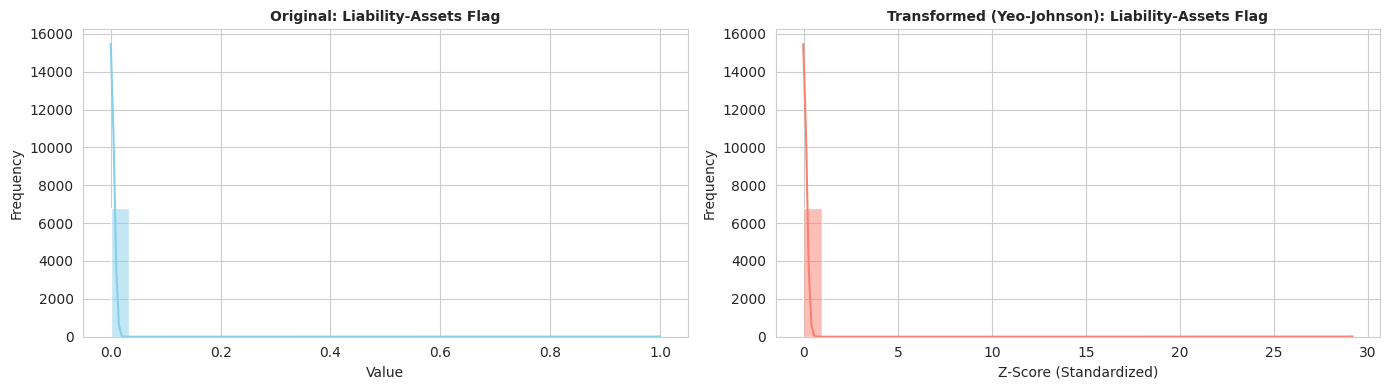

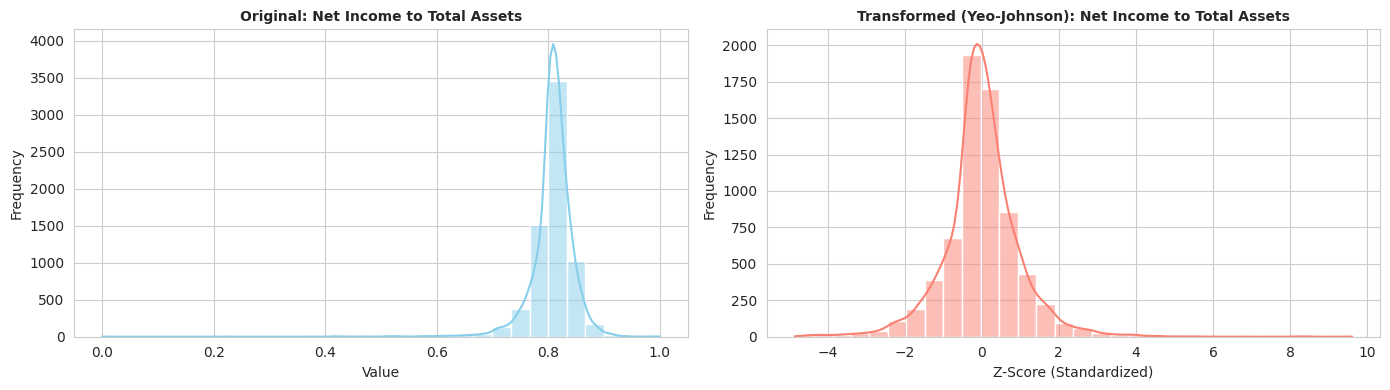

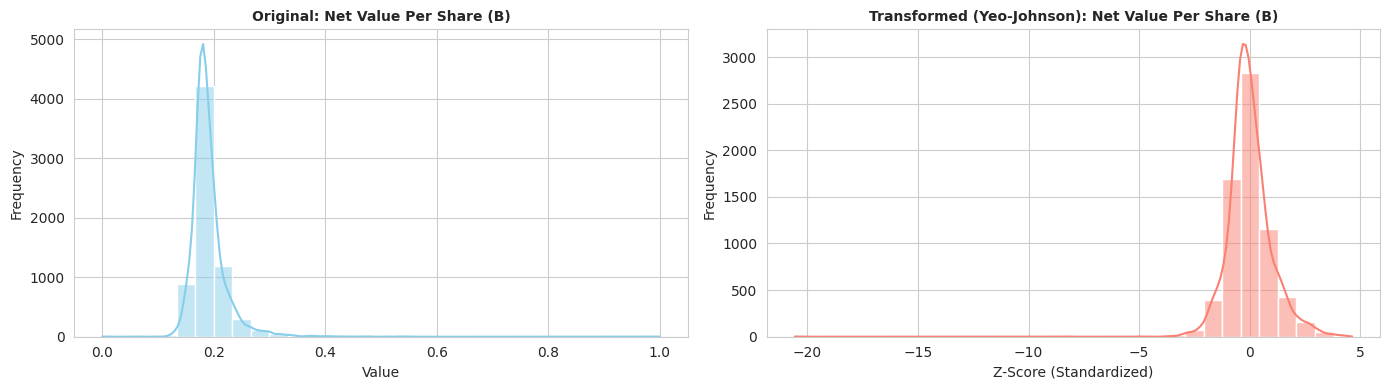

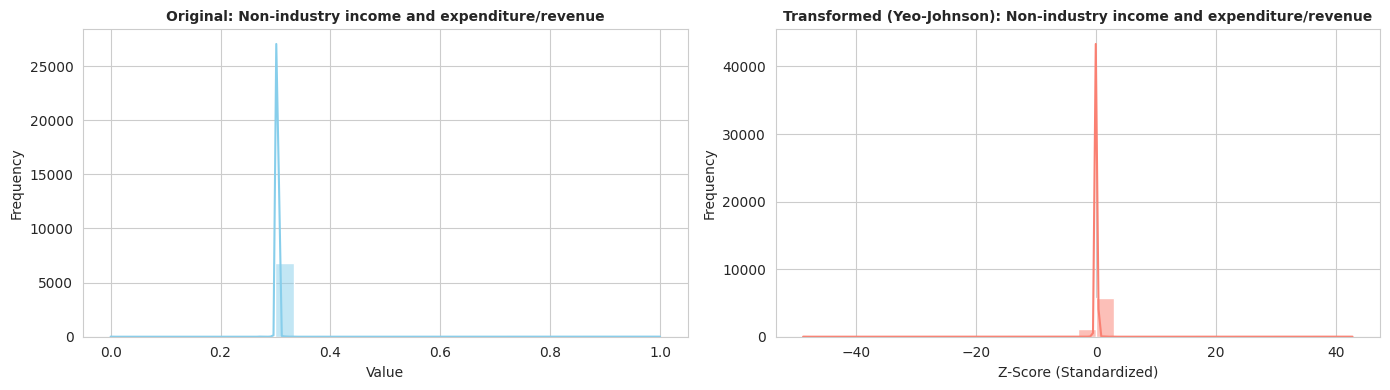

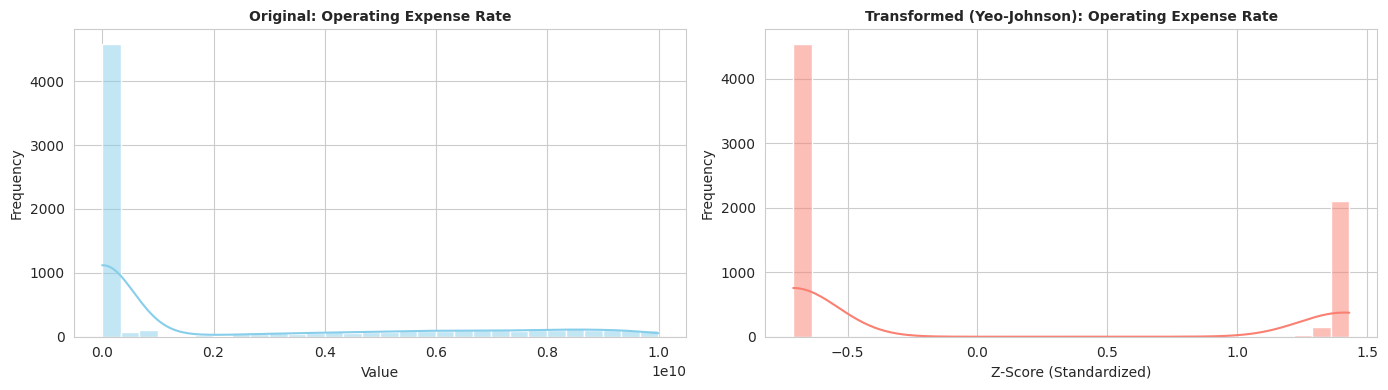

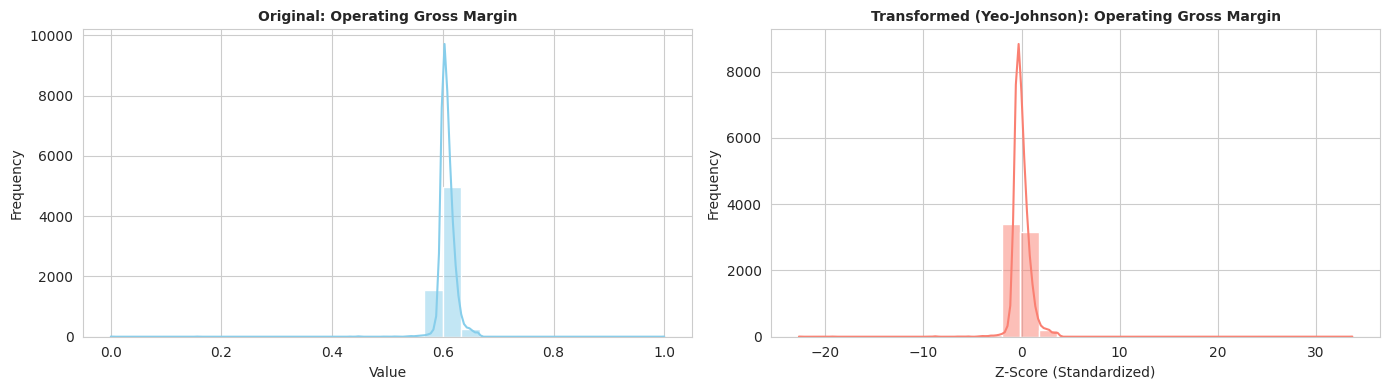

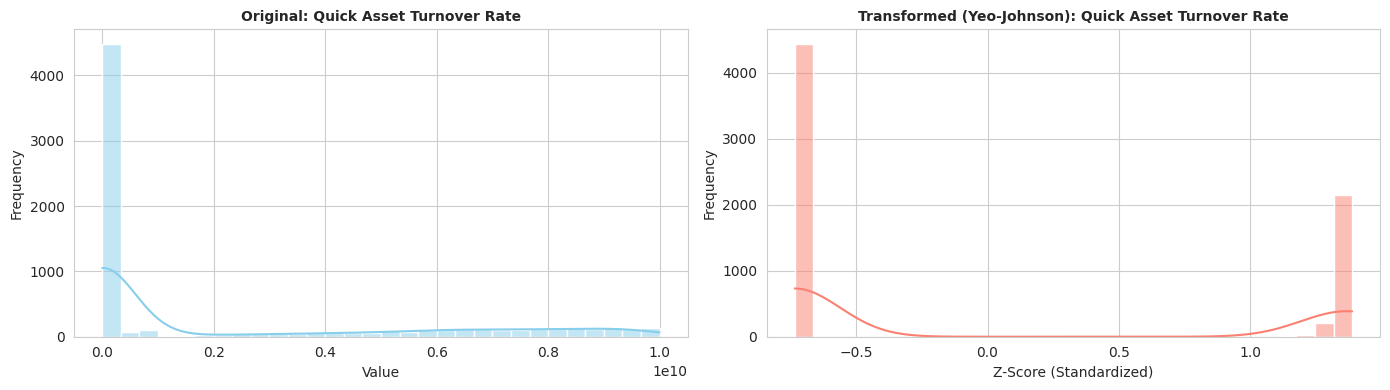

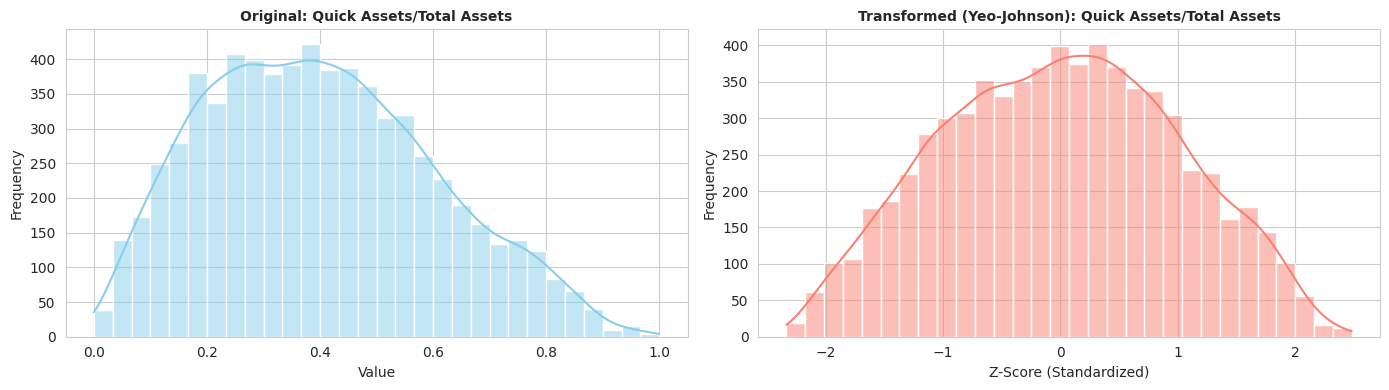

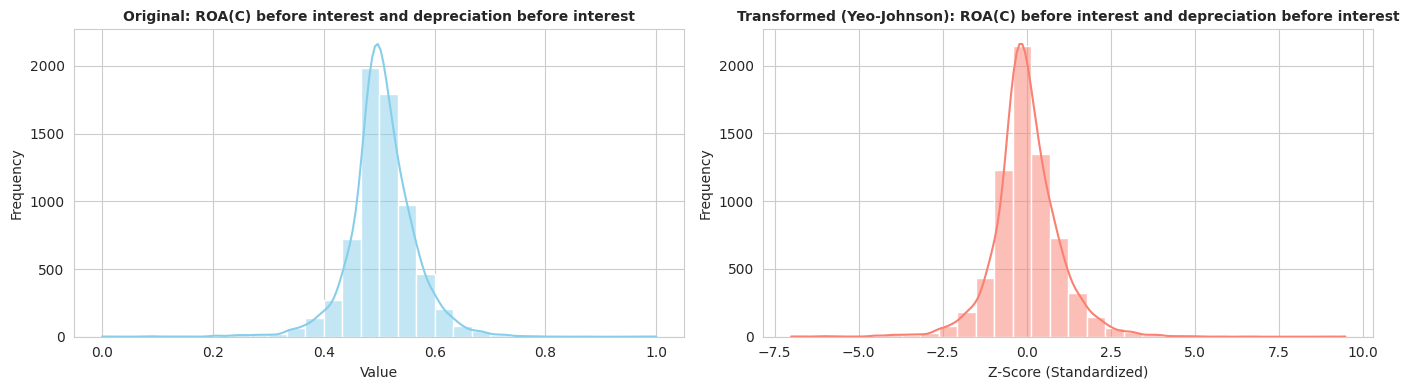

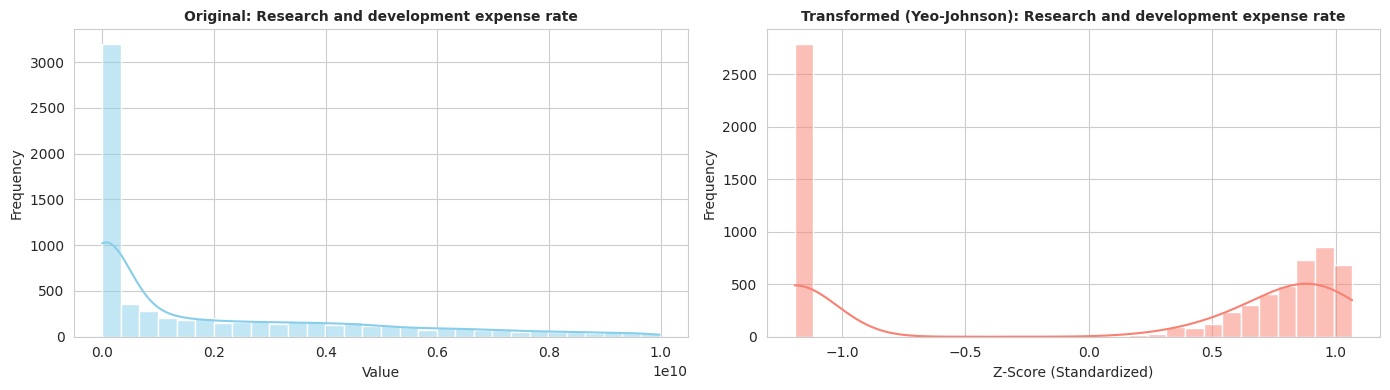

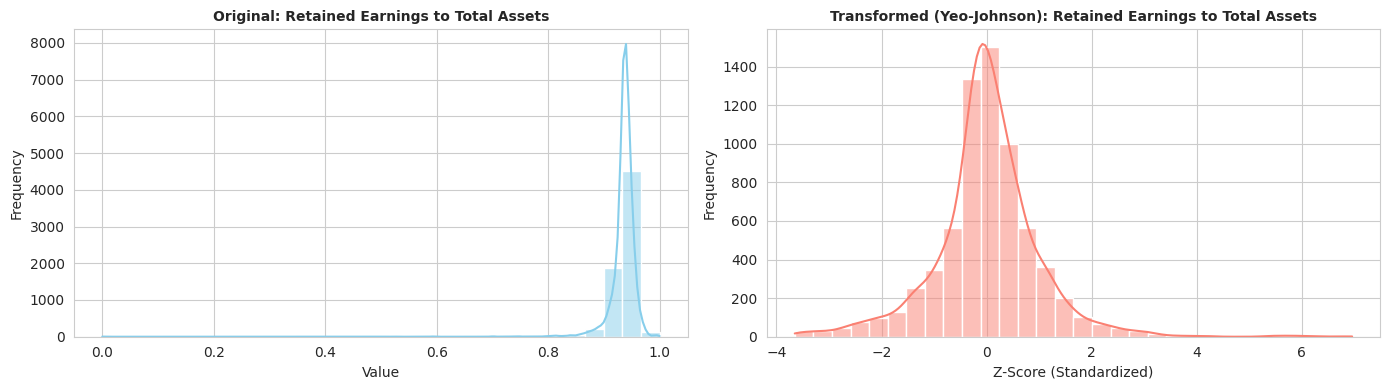

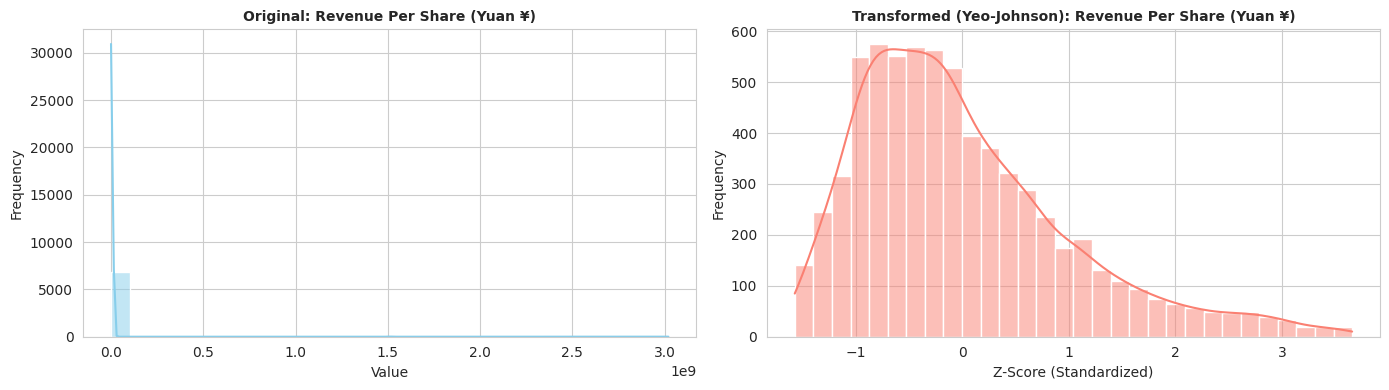

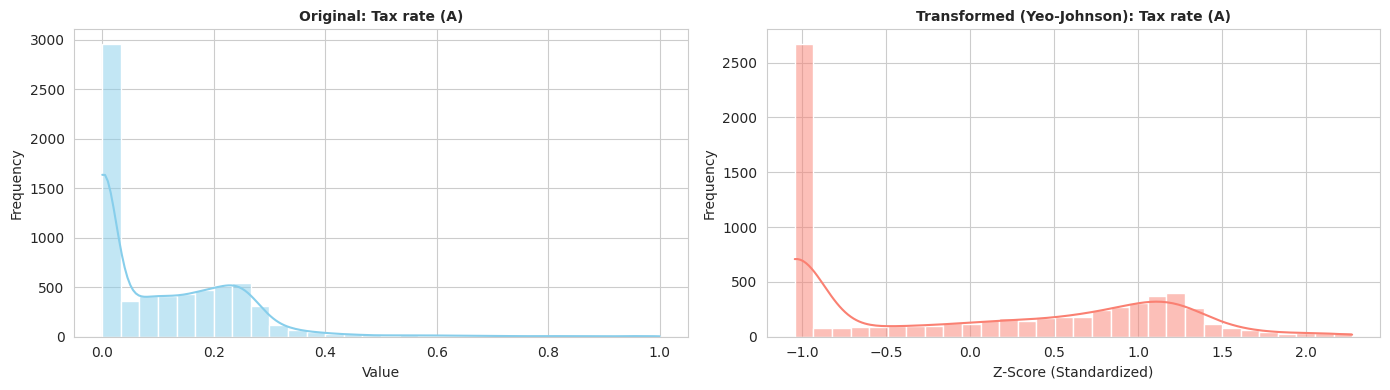

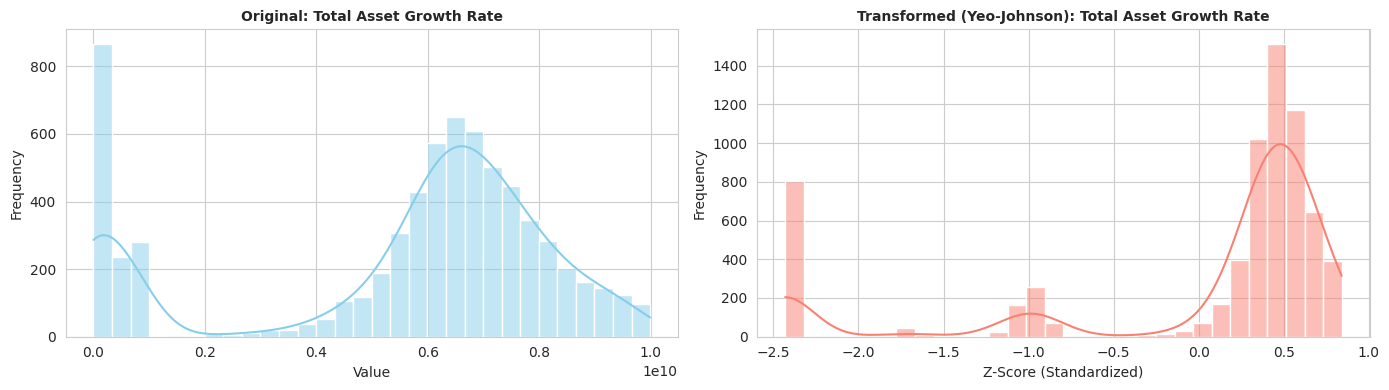

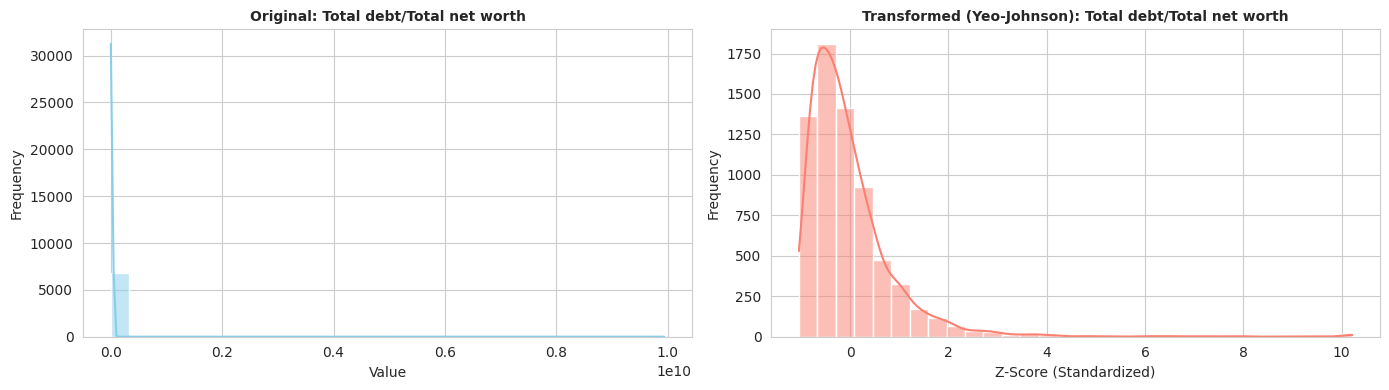

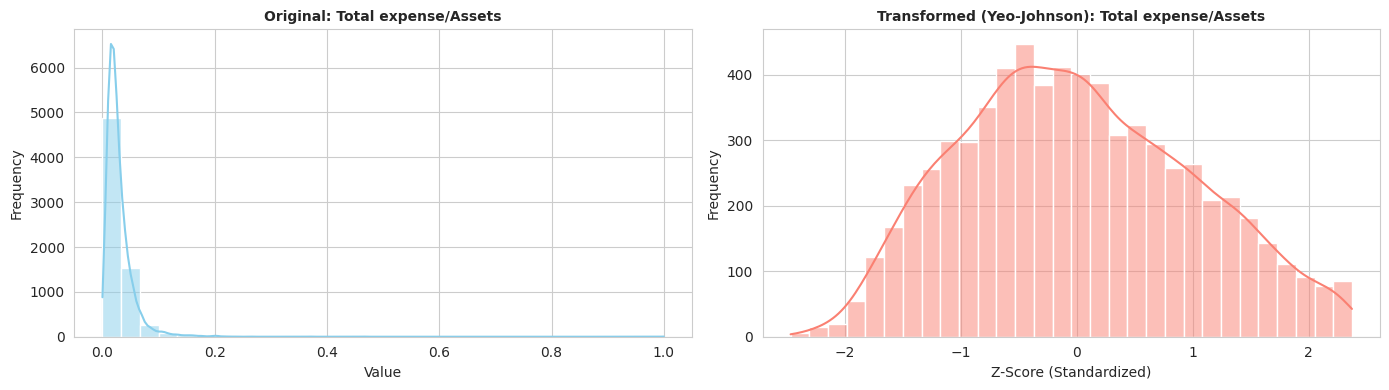

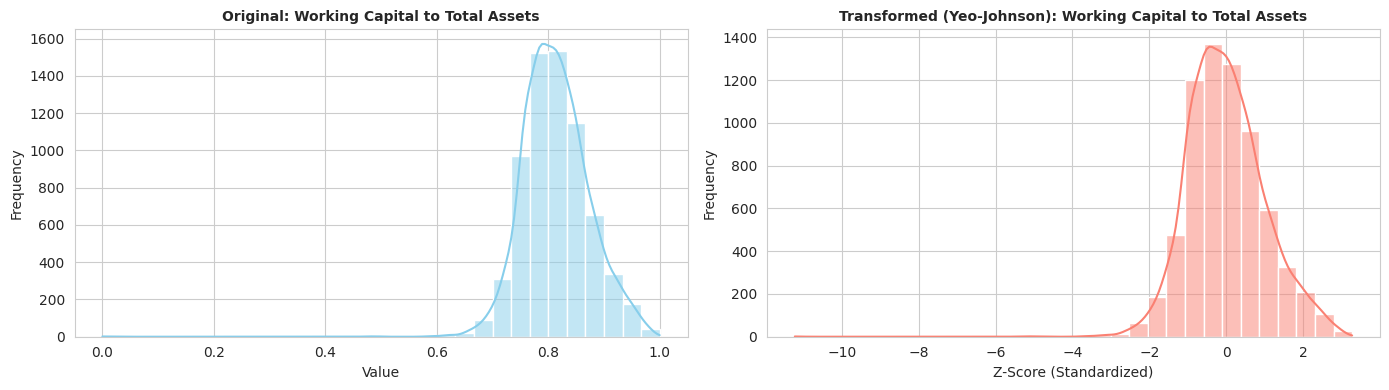

In [ ]:
#we will imply Yeo-Johnson transformation to handle the skewness of the data
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_trans_array = pt.fit_transform(X)


X_transformed = pd.DataFrame(X_trans_array, columns=X.columns)


sns.set_style("whitegrid")

for col in finalFeatures:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    #left, features without Yeo-Johnson Transformation
    sns.histplot(X[col], kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title(f'Original: {col}', fontsize=10, fontweight='bold')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')

    #right, features with Yeo-Johnson Transformation
    sns.histplot(X_transformed[col], kde=True, ax=axes[1], color='salmon', bins=30)
    axes[1].set_title(f'Transformed (Yeo-Johnson): {col}', fontsize=10, fontweight='bold')
    axes[1].set_xlabel('Z-Score (Standardized)')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [ ]:
df_final = X_transformed.copy()
df_final['Bankruptcy'] = y.reset_index(drop=True)

print("dataset dimensions:", df_final.shape)
print("Check for NaN:", df_final.isnull().sum().sum())


save_path2 = 'processed_bankruptcy_data.csv'
df_final.to_csv(save_path2, index=False)
print("\ndataset saved")

dataset dimensions: (6819, 29)
Check for NaN: 0

dataset saved
